In [1]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Use only tabular data for clarity attribute

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load Data and Define Inputs
# -----------------------------
df = pd.read_csv("/content/Final_shape_colorintensity_cut_clartyupdated_dataset.csv")

# Define your tabular feature columns (update as needed)

target_columns = ["clarity", "cut","color_intensity","shape"]
image_column = "Image id"


feature_columns = [col for col in df.columns if col not in target_columns + [image_column]]

X_tab = df[feature_columns]

X_tab.head()

,Contrast,Homogeneity,Energy,Correlation,Edge_Density,Intensity_Variance,Hue_Std,Saturation_Std,Aspect_Ratio,Perimeter,Area,Circularity,Convexity,Edge_Sharpness,Symmetry
0,3.261303,0.888582,0.749260,0.995556,2.170091,750.484431,47.795822,63.518461,1.002882,1373.254833,117885.0,0.785536,0.993444,22.581386,0.972512
1,8.984511,0.844536,0.772806,0.995882,5.503750,3341.218207,34.060722,25.861783,0.656780,1293.124012,105705.5,0.794378,0.995606,43.235618,0.925087
2,10.969107,0.845418,0.791677,0.995696,8.323262,4394.860524,45.950897,12.087048,0.623529,306.676186,1695.0,0.226475,0.662368,135.527886,0.926447
3,12.973305,0.850540,0.797043,0.989103,7.084543,2284.820490,43.158840,24.812120,1.092697,1175.928057,727.0,0.000475,0.007589,226.929642,0.935908
4,8.719243,0.873483,0.814791,0.996255,6.012195,3506.119206,39.389006,16.391353,1.935484,239.965510,501.0,0.109333,0.442971,106.968626,0.945912


In [ ]:
image_paths = df['Image id']

In [ ]:
# OneHotEncode the target labels
encoder = OneHotEncoder(sparse_output=False)
y_clarity = encoder.fit_transform(df[[target_columns[0]]])
y_cut     = encoder.fit_transform(df[[target_columns[1]]])
y_color_intensity   = encoder.fit_transform(df[[target_columns[2]]])
y_shape   = encoder.fit_transform(df[[target_columns[3]]])


# -----------------------------
# 2. Split Data (including image paths)
# -----------------------------
# Split into train and temp (test+validation)
X_tab_train, X_tab_temp, img_paths_train, img_paths_temp, \
    y_clarity_train, y_clarity_temp, y_cut_train, y_cut_temp , y_color_intensity_train, y_color_intensity_temp,y_shape_train , y_shape_temp = train_test_split(
    X_tab, image_paths, y_clarity, y_cut, y_color_intensity, y_shape, test_size=0.4, random_state=42
)

# Further split temp into validation and test sets
X_tab_val, X_tab_test, img_paths_val, img_paths_test, \
    y_clarity_val, y_clarity_test, y_cut_val, y_cut_test,y_color_intensity_val, y_color_intensity_test, y_shape_val , y_shape_test  = train_test_split(
    X_tab_temp, img_paths_temp, y_clarity_temp, y_cut_temp, y_color_intensity_temp , y_shape_temp, test_size=0.5, random_state=42
)

In [ ]:

# Combine tabular features and image paths into a DataFrame
train_df = X_tab_train.copy()
train_df["img_path"] = img_paths_train

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Oversample using y_clarity (to maintain consistency across targets)
train_df_resampled, y_clarity_resampled = ros.fit_resample(train_df, y_clarity_train)

# Extract resampled tabular data and image paths
X_tab_train_resampled = train_df_resampled.drop(columns=["img_path"])  # Remove img_path before training
img_paths_train_resampled = train_df_resampled["img_path"].values

# Get the indices used for resampling
resample_indices = ros.sample_indices_

# Apply the same resampling indices to other target labels
y_color_intensity_resampled = y_color_intensity_train[resample_indices]
y_cut_resampled = y_cut_train[resample_indices]
y_shape_resampled = y_shape_train[resample_indices]

# Convert targets back to NumPy arrays
y_clarity_resampled = np.array(y_clarity_resampled)
y_color_intensity_resampled = np.array(y_color_intensity_resampled)
y_cut_resampled = np.array(y_cut_resampled)
y_shape_resampled = np.array(y_shape_resampled)

# print all lengths
print(len(X_tab_train_resampled), len(img_paths_train_resampled),
      len(y_clarity_resampled), len(y_color_intensity_resampled),
      len(y_cut_resampled), len(y_shape_resampled))

19952 19952 19952 19952 19952 19952


In [ ]:
# -----------------------------
# 3. Preprocess Tabular Data and Load Images
# -----------------------------
# Scale the tabular features
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train_resampled)
X_tab_val_scaled   = scaler.transform(X_tab_val)
X_tab_test_scaled  = scaler.transform(X_tab_test)

# Define a helper function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Check if the image path exists
    if os.path.exists(image_path):
        # Load and preprocess the image if it exists
        print(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Scale pixel values to [0, 1]
        return img_array / 255.0
    else:
        # If image does not exist, print a warning and return None
        print(f"Warning: {image_path} does not exist. Skipping...")
        return None

# Load images for each split (this may take some time depending on dataset size)
train_images = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_train_resampled) if img is not None])
val_images   = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_val) if img is not None])
test_images  = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_test) if img is not None])



Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1996.jpg
/content/drive/MyDrive/Reupload_Images/Yellow Sapphire/Yellow Sapphire 1135.jpg
/content/drive/MyDrive/Reupload_Images/Ruby/Ruby R13245.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3719.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 1161.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1370.jpg
/content/drive/MyDrive/Reupload_Images/Green Sapphire/Green Sapphire 76.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3599.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1456.jpg
/content/drive/MyDrive/Reupload_Images/Padparadscha Sapphire/Padparadscha Sapphire S17461.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 192.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3623.jpg
/content/drive/MyDrive/Reupload_

In [ ]:
# Convert labels to NumPy arrays (using correct resampled labels)
Y_clarity_train_array = np.array(y_clarity_resampled)
Y_cut_train_array     = np.array(y_cut_resampled)
Y_color_intensity_train_array   = np.array(y_color_intensity_resampled)
Y_shape_train_array   = np.array(y_shape_resampled)

Y_clarity_val_array = np.array(y_clarity_val)
Y_cut_val_array     = np.array(y_cut_val)
Y_color_intensity_val_array   = np.array(y_color_intensity_val)
Y_shape_val_array   = np.array(y_shape_val)

Y_clarity_test_array = np.array(y_clarity_test)
Y_cut_test_array     = np.array(y_cut_test)
Y_color_intensity_test_array   = np.array(y_color_intensity_test)
Y_shape_test_array   = np.array(y_shape_test)

In [ ]:
# -----------------------------
# 5. Build the Multi-Input Model
# -----------------------------
# Tabular (MLP) branch
tab_input = keras.Input(shape=(X_tab_train_scaled.shape[1],), name="tab_input")
t = layers.Dense(128, activation="relu")(tab_input)
t = layers.Dropout(0.3)(t)
t = layers.Dense(256, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(128, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(64, activation="relu")(t)

# Image (CNN) branch – adjust target_size and architecture as needed
img_input = keras.Input(shape=(128, 128, 3), name="img_input")
c = layers.Conv2D(32, (3, 3), activation="relu")(img_input)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(64, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(128, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Flatten()(c)
c = layers.Dense(64, activation="relu")(c)

# Combine both branches
combined = layers.concatenate([t, c])
combined = layers.Dense(128, activation="relu")(combined)

# Output layers for multi-output classification
clarity_output = layers.Dense(Y_clarity_train_array.shape[1], activation="softmax", name="clarity")(t)
cut_output     = layers.Dense(Y_cut_train_array.shape[1], activation="softmax", name="cut")(combined)
color_intensity_output   = layers.Dense(Y_color_intensity_train_array.shape[1], activation="softmax", name="color_intensity")(c)
shape_output   = layers.Dense(Y_shape_train_array.shape[1], activation="softmax", name="shape")(combined)

# Define the model with two inputs
model = keras.Model(inputs=[tab_input, img_input],
                    outputs=[clarity_output,cut_output ,color_intensity_output , shape_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "clarity": "categorical_crossentropy",
        "cut": "categorical_crossentropy",
        "color_intensity": "categorical_crossentropy",
        "shape": "categorical_crossentropy"
    },
    metrics={
        "clarity": "accuracy",
        "cut": "accuracy",
        "color_intensity": "accuracy",
        "shape": "accuracy"
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tab_input (InputLayer)    │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          2,048 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      1,605,696 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense_3[0][0],         │
│                      

 Total params: 1,796,009 (6.85 MB)

 Trainable params: 1,796,009 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# -----------------------------
# 6. Train the Model
# -----------------------------
history = model.fit(
    [X_tab_train_scaled, train_images],
    {"clarity": Y_clarity_train_array, "cut": Y_cut_train_array , "color_intensity": Y_color_intensity_train_array, "shape": Y_shape_train_array},
    validation_data=(
        [X_tab_val_scaled, val_images],
        {"clarity": Y_clarity_val_array,"cut": Y_cut_val_array ,  "color_intensity": Y_color_intensity_val_array,  "shape": Y_shape_val_array}
    ),
    epochs=10,
    batch_size=32,
    verbose=1
)

# -----------------------------
# 7. Evaluate the Model
# -----------------------------
# Predict on the test set
predictions = model.predict([X_tab_test_scaled, test_images])
# Convert probabilities to predicted class indices
Y_test_pred = [np.argmax(pred, axis=1) for pred in predictions]

# Convert one-hot test labels back to class indices
Y_test_true = [
    np.argmax(Y_clarity_test_array, axis=1),
    np.argmax(Y_cut_test_array, axis=1),
    np.argmax(Y_color_intensity_test_array, axis=1),
    np.argmax(Y_shape_test_array, axis=1)
]

# Print classification reports for each output
for i, name in enumerate(["Clarity", "Cut","Color_intensity" , "Shape"]):
    print(f"{name} Classification Report:\n", classification_report(Y_test_true[i], Y_test_pred[i]))

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 143s 223ms/step - clarity_accuracy: 0.4344 - clarity_loss: 1.1718 - color_intensity_accuracy: 0.5538 - color_intensity_loss: 1.2248 - cut_accuracy: 0.8373 - cut_loss: 0.6419 - loss: 4.1816 - shape_accuracy: 0.6527 - shape_loss: 1.1430 - val_clarity_accuracy: 0.3558 - val_clarity_loss: 1.0886 - val_color_intensity_accuracy: 0.5570 - val_color_intensity_loss: 1.2456 - val_cut_accuracy: 0.8833 - val_cut_loss: 0.4709 - val_loss: 3.4674 - val_shape_accuracy: 0.8243 - val_shape_loss: 0.6739
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 135s 216ms/step - clarity_accuracy: 0.5788 - clarity_loss: 0.8517 - color_intensity_accuracy: 0.7328 - color_intensity_loss: 0.7176 - cut_accuracy: 0.9379 - cut_loss: 0.2334 - loss: 2.1470 - shape_accuracy: 0.9060 - shape_loss: 0.3442 - val_clarity_accuracy: 0.3841 - val_clarity_loss: 1.0806 - val_color_intensity_accuracy: 0.5394 - val_color_intensity_loss: 1.3144 - val_cut_accuracy: 0.8992 - val_cut_loss: 0.4471 - val_loss: 3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# :# Output layers all ---- combined (t, c)  , Getting train accuracy for clarity high

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load Data and Define Inputs
# -----------------------------
df = pd.read_csv("/content/Final_shape_colorintensity_cut_clartyupdated_dataset.csv")

# Define your tabular feature columns (update as needed)

target_columns = ["clarity", "cut","color_intensity","shape"]
image_column = "Image id"


feature_columns = [col for col in df.columns if col not in target_columns + [image_column]]

X_tab = df[feature_columns]

X_tab.head()

,Contrast,Homogeneity,Energy,Correlation,Edge_Density,Intensity_Variance,Hue_Std,Saturation_Std,Aspect_Ratio,Perimeter,Area,Circularity,Convexity,Edge_Sharpness,Symmetry
0,3.261303,0.888582,0.749260,0.995556,2.170091,750.484431,47.795822,63.518461,1.002882,1373.254833,117885.0,0.785536,0.993444,22.581386,0.972512
1,8.984511,0.844536,0.772806,0.995882,5.503750,3341.218207,34.060722,25.861783,0.656780,1293.124012,105705.5,0.794378,0.995606,43.235618,0.925087
2,10.969107,0.845418,0.791677,0.995696,8.323262,4394.860524,45.950897,12.087048,0.623529,306.676186,1695.0,0.226475,0.662368,135.527886,0.926447
3,12.973305,0.850540,0.797043,0.989103,7.084543,2284.820490,43.158840,24.812120,1.092697,1175.928057,727.0,0.000475,0.007589,226.929642,0.935908
4,8.719243,0.873483,0.814791,0.996255,6.012195,3506.119206,39.389006,16.391353,1.935484,239.965510,501.0,0.109333,0.442971,106.968626,0.945912


In [2]:
image_paths = df['Image id']

In [3]:
# OneHotEncode the target labels
encoder = OneHotEncoder(sparse_output=False)
y_clarity = encoder.fit_transform(df[[target_columns[0]]])
y_cut     = encoder.fit_transform(df[[target_columns[1]]])
y_color_intensity   = encoder.fit_transform(df[[target_columns[2]]])
y_shape   = encoder.fit_transform(df[[target_columns[3]]])



# -----------------------------
# 2. Split Data (including image paths)
# -----------------------------
# Split into train and temp (test+validation)
X_tab_train, X_tab_temp, img_paths_train, img_paths_temp, \
    y_clarity_train, y_clarity_temp, y_cut_train, y_cut_temp , y_color_intensity_train, y_color_intensity_temp,y_shape_train , y_shape_temp = train_test_split(
    X_tab, image_paths, y_clarity, y_cut, y_color_intensity, y_shape, test_size=0.4, random_state=42
)

# Further split temp into validation and test sets
X_tab_val, X_tab_test, img_paths_val, img_paths_test, \
    y_clarity_val, y_clarity_test, y_cut_val, y_cut_test,y_color_intensity_val, y_color_intensity_test, y_shape_val , y_shape_test  = train_test_split(
    X_tab_temp, img_paths_temp, y_clarity_temp, y_cut_temp, y_color_intensity_temp , y_shape_temp, test_size=0.5, random_state=42
)

In [5]:

# Combine tabular features and image paths into a DataFrame
train_df = X_tab_train.copy()
train_df["img_path"] = img_paths_train

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Oversample using y_clarity (to maintain consistency across targets)
train_df_resampled, y_clarity_resampled = ros.fit_resample(train_df, y_clarity_train)

# Extract resampled tabular data and image paths
X_tab_train_resampled = train_df_resampled.drop(columns=["img_path"])  # Remove img_path before training
img_paths_train_resampled = train_df_resampled["img_path"].values

# Get the indices used for resampling
resample_indices = ros.sample_indices_

# Apply the same resampling indices to other target labels
y_color_intensity_resampled = y_color_intensity_train[resample_indices]
y_cut_resampled = y_cut_train[resample_indices]
y_shape_resampled = y_shape_train[resample_indices]

# Convert targets back to NumPy arrays
y_clarity_resampled = np.array(y_clarity_resampled)
y_color_intensity_resampled = np.array(y_color_intensity_resampled)
y_cut_resampled = np.array(y_cut_resampled)
y_shape_resampled = np.array(y_shape_resampled)

# print all lengths
print(len(X_tab_train_resampled), len(img_paths_train_resampled),
      len(y_clarity_resampled), len(y_color_intensity_resampled),
      len(y_cut_resampled), len(y_shape_resampled))

19952 19952 19952 19952 19952 19952


In [6]:
# -----------------------------
# 3. Preprocess Tabular Data and Load Images
# -----------------------------
# Scale the tabular features
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train_resampled)
X_tab_val_scaled   = scaler.transform(X_tab_val)
X_tab_test_scaled  = scaler.transform(X_tab_test)

# Define a helper function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Check if the image path exists
    if os.path.exists(image_path):
        # Load and preprocess the image if it exists
        print(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Scale pixel values to [0, 1]
        return img_array / 255.0
    else:
        # If image does not exist, print a warning and return None
        print(f"Warning: {image_path} does not exist. Skipping...")
        return None

# Load images for each split (this may take some time depending on dataset size)
train_images = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_train_resampled) if img is not None])
val_images   = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_val) if img is not None])
test_images  = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_test) if img is not None])

/content/drive/MyDrive/Reupload_Images/Ruby/Ruby R12692.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 1029.jpg
/content/drive/MyDrive/Reupload_Images/Green Sapphire/Green Sapphire 702.jpg
/content/drive/MyDrive/Reupload_Images/Ruby/Ruby R12881.jpg
/content/drive/MyDrive/Reupload_Images/Ruby/Ruby R5774.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 863.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 74.jpg
/content/drive/MyDrive/Reupload_Images/Green Sapphire/Green Sapphire 246.jpg
/content/drive/MyDrive/Reupload_Images/Green Sapphire/Green Sapphire 222.jpg
/content/drive/MyDrive/Reupload_Images/Padparadscha Sapphire/Padparadscha Sapphire S9444.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 2055.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 602.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 363.jpg
/content/drive/MyDrive/Reupload_Images/Ruby/Ru

KeyboardInterrupt: 

In [ ]:
# Convert labels to NumPy arrays (using correct resampled labels)
Y_clarity_train_array = np.array(y_clarity_resampled)
Y_cut_train_array     = np.array(y_cut_resampled)
Y_color_intensity_train_array   = np.array(y_color_intensity_resampled)
Y_shape_train_array   = np.array(y_shape_resampled)

Y_clarity_val_array = np.array(y_clarity_val)
Y_cut_val_array     = np.array(y_cut_val)
Y_color_intensity_val_array   = np.array(y_color_intensity_val)
Y_shape_val_array   = np.array(y_shape_val)

Y_clarity_test_array = np.array(y_clarity_test)
Y_cut_test_array     = np.array(y_cut_test)
Y_color_intensity_test_array   = np.array(y_color_intensity_test)
Y_shape_test_array   = np.array(y_shape_test)

In [ ]:
# -----------------------------
# 5. Build the Multi-Input Model
# -----------------------------
# Tabular (MLP) branch
tab_input = keras.Input(shape=(X_tab_train_scaled.shape[1],), name="tab_input")
t = layers.Dense(128, activation="relu")(tab_input)
t = layers.Dropout(0.3)(t)
t = layers.Dense(256, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(128, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(64, activation="relu")(t)

# Image (CNN) branch – adjust target_size and architecture as needed
img_input = keras.Input(shape=(128, 128, 3), name="img_input")
c = layers.Conv2D(32, (3, 3), activation="relu")(img_input)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(64, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(128, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Flatten()(c)
c = layers.Dense(64, activation="relu")(c)

# Combine both branches
combined = layers.concatenate([t, c])
combined = layers.Dense(128, activation="relu")(combined)

# Output layers for multi-output classification
clarity_output = layers.Dense(Y_clarity_train_array.shape[1], activation="softmax", name="clarity")(combined)
cut_output     = layers.Dense(Y_cut_train_array.shape[1], activation="softmax", name="cut")(combined)
color_intensity_output   = layers.Dense(Y_color_intensity_train_array.shape[1], activation="softmax", name="color_intensity")(combined)
shape_output   = layers.Dense(Y_shape_train_array.shape[1], activation="softmax", name="shape")(combined)

# Define the model with two inputs
model = keras.Model(inputs=[tab_input, img_input],
                    outputs=[clarity_output,cut_output ,color_intensity_output , shape_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "clarity": "categorical_crossentropy",
        "cut": "categorical_crossentropy",
        "color_intensity": "categorical_crossentropy",
        "shape": "categorical_crossentropy"
    },
    metrics={
        "clarity": "accuracy",
        "cut": "accuracy",
        "color_intensity": "accuracy",
        "shape": "accuracy"
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tab_input (InputLayer)    │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          2,048 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      1,605,696 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense_3[0][0],         │
│                      

 Total params: 1,796,969 (6.85 MB)

 Trainable params: 1,796,969 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# -----------------------------
# 6. Train the Model
# -----------------------------
history = model.fit(
    [X_tab_train_scaled, train_images],
    {"clarity": Y_clarity_train_array, "cut": Y_cut_train_array , "color_intensity": Y_color_intensity_train_array, "shape": Y_shape_train_array},
    validation_data=(
        [X_tab_val_scaled, val_images],
        {"clarity": Y_clarity_val_array,"cut": Y_cut_val_array ,  "color_intensity": Y_color_intensity_val_array,  "shape": Y_shape_val_array}
    ),
    epochs=10,
    batch_size=32,
    verbose=1
)

# -----------------------------
# 7. Evaluate the Model
# -----------------------------
# Predict on the test set
predictions = model.predict([X_tab_test_scaled, test_images])
# Convert probabilities to predicted class indices
Y_test_pred = [np.argmax(pred, axis=1) for pred in predictions]

# Convert one-hot test labels back to class indices
Y_test_true = [
    np.argmax(Y_clarity_test_array, axis=1),
    np.argmax(Y_cut_test_array, axis=1),
    np.argmax(Y_color_intensity_test_array, axis=1),
    np.argmax(Y_shape_test_array, axis=1)
]

# Print classification reports for each output
for i, name in enumerate(["Clarity", "Cut","Color_intensity" , "Shape"]):
    print(f"{name} Classification Report:\n", classification_report(Y_test_true[i], Y_test_pred[i]))

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 140s 219ms/step - clarity_accuracy: 0.4733 - clarity_loss: 1.0900 - color_intensity_accuracy: 0.5419 - color_intensity_loss: 1.3176 - cut_accuracy: 0.8326 - cut_loss: 0.6760 - loss: 4.2080 - shape_accuracy: 0.6547 - shape_loss: 1.1244 - val_clarity_accuracy: 0.3618 - val_clarity_loss: 1.1164 - val_color_intensity_accuracy: 0.5450 - val_color_intensity_loss: 1.1678 - val_cut_accuracy: 0.8873 - val_cut_loss: 0.4775 - val_loss: 3.4625 - val_shape_accuracy: 0.8247 - val_shape_loss: 0.7106
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - clarity_accuracy: 0.6650 - clarity_loss: 0.6843 - color_intensity_accuracy: 0.6977 - color_intensity_loss: 0.7813 - cut_accuracy: 0.9422 - cut_loss: 0.2335 - loss: 2.0522 - shape_accuracy: 0.9109 - shape_loss: 0.3531 - val_clarity_accuracy: 0.5151 - val_clarity_loss: 0.9761 - val_color_intensity_accuracy: 0.5653 - val_color_intensity_loss: 1.1521 - val_cut_accuracy: 0.8908 - val_cut_loss: 0.4673 - val_loss: 3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

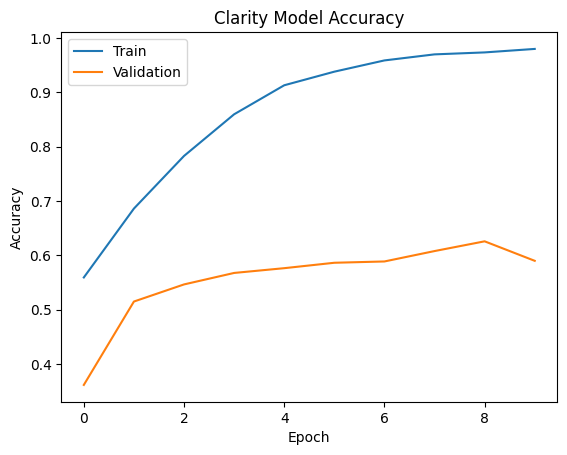

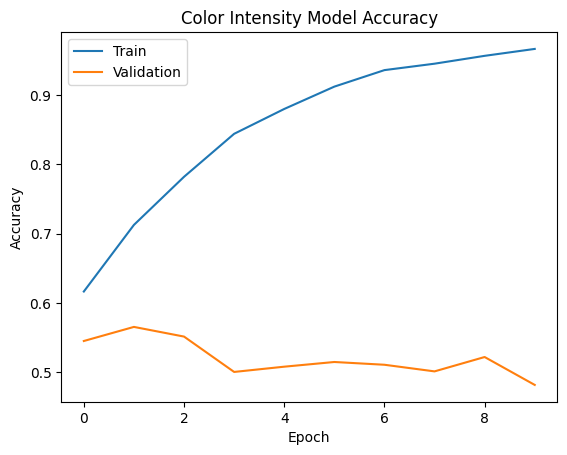

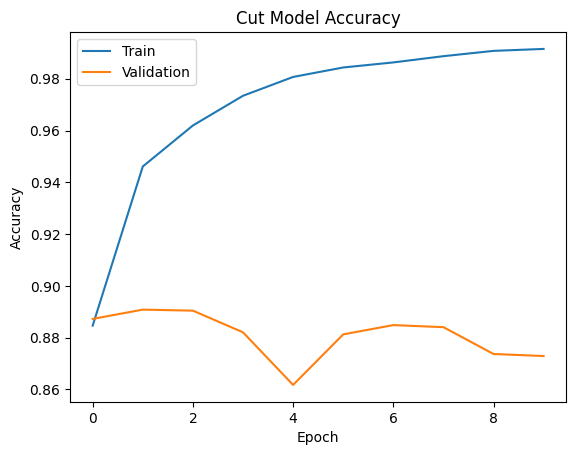

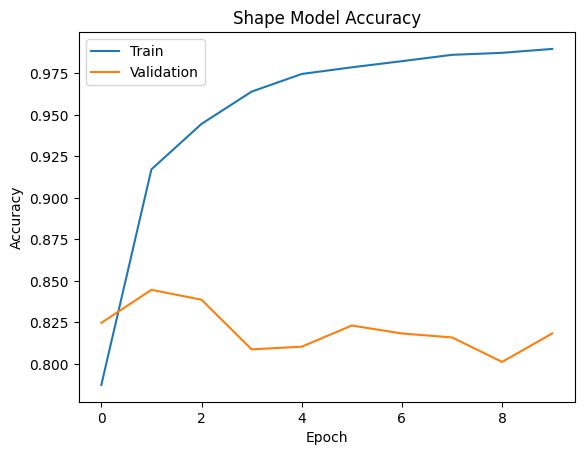

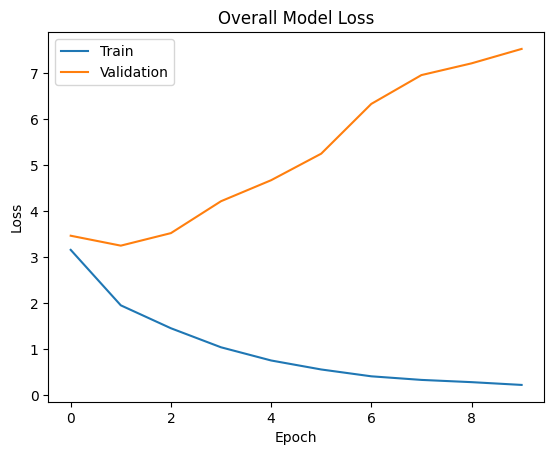

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy metrics
plt.plot(history.history['clarity_accuracy'])
plt.plot(history.history['val_clarity_accuracy'])
plt.title('Clarity Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['color_intensity_accuracy'])  # Corrected key
plt.plot(history.history['val_color_intensity_accuracy'])  # Corrected key
plt.title('Color Intensity Model Accuracy')  # Updated title for clarity
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['cut_accuracy'])
plt.plot(history.history['val_cut_accuracy'])
plt.title('Cut Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['shape_accuracy'])  # Added shape model accuracy plot
plt.plot(history.history['val_shape_accuracy'])
plt.title('Shape Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Add One epoche to see accuracy for clarity attribute

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load Data and Define Inputs
# -----------------------------
df = pd.read_csv("/content/Final_shape_colorintensity_cut_clartyupdated_dataset.csv")

# Define your tabular feature columns (update as needed)

target_columns = ["clarity", "cut","color_intensity","shape"]
image_column = "Image id"


feature_columns = [col for col in df.columns if col not in target_columns + [image_column]]

X_tab = df[feature_columns]

X_tab.head()

,Contrast,Homogeneity,Energy,Correlation,Edge_Density,Intensity_Variance,Hue_Std,Saturation_Std,Aspect_Ratio,Perimeter,Area,Circularity,Convexity,Edge_Sharpness,Symmetry
0,3.261303,0.888582,0.749260,0.995556,2.170091,750.484431,47.795822,63.518461,1.002882,1373.254833,117885.0,0.785536,0.993444,22.581386,0.972512
1,8.984511,0.844536,0.772806,0.995882,5.503750,3341.218207,34.060722,25.861783,0.656780,1293.124012,105705.5,0.794378,0.995606,43.235618,0.925087
2,10.969107,0.845418,0.791677,0.995696,8.323262,4394.860524,45.950897,12.087048,0.623529,306.676186,1695.0,0.226475,0.662368,135.527886,0.926447
3,12.973305,0.850540,0.797043,0.989103,7.084543,2284.820490,43.158840,24.812120,1.092697,1175.928057,727.0,0.000475,0.007589,226.929642,0.935908
4,8.719243,0.873483,0.814791,0.996255,6.012195,3506.119206,39.389006,16.391353,1.935484,239.965510,501.0,0.109333,0.442971,106.968626,0.945912


In [ ]:
image_paths = df['Image id']

In [ ]:
# OneHotEncode the target labels
encoder = OneHotEncoder(sparse_output=False)
y_clarity = encoder.fit_transform(df[[target_columns[0]]])
y_cut     = encoder.fit_transform(df[[target_columns[1]]])
y_color_intensity   = encoder.fit_transform(df[[target_columns[2]]])
y_shape   = encoder.fit_transform(df[[target_columns[3]]])

# -----------------------------
# 2. Split Data (including image paths)
# -----------------------------
# Split into train and temp (test+validation)
X_tab_train, X_tab_temp, img_paths_train, img_paths_temp, \
    y_clarity_train, y_clarity_temp, y_cut_train, y_cut_temp , y_color_intensity_train, y_color_intensity_temp,y_shape_train , y_shape_temp = train_test_split(
    X_tab, image_paths, y_clarity, y_cut, y_color_intensity, y_shape, test_size=0.4, random_state=42
)

# Further split temp into validation and test sets
X_tab_val, X_tab_test, img_paths_val, img_paths_test, \
    y_clarity_val, y_clarity_test, y_cut_val, y_cut_test,y_color_intensity_val, y_color_intensity_test, y_shape_val , y_shape_test  = train_test_split(
    X_tab_temp, img_paths_temp, y_clarity_temp, y_cut_temp, y_color_intensity_temp , y_shape_temp, test_size=0.5, random_state=42
)

In [ ]:

# Combine tabular features and image paths into a DataFrame
train_df = X_tab_train.copy()
train_df["img_path"] = img_paths_train

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Oversample using y_clarity (to maintain consistency across targets)
train_df_resampled, y_clarity_resampled = ros.fit_resample(train_df, y_clarity_train)

# Extract resampled tabular data and image paths
X_tab_train_resampled = train_df_resampled.drop(columns=["img_path"])  # Remove img_path before training
img_paths_train_resampled = train_df_resampled["img_path"].values

# Get the indices used for resampling
resample_indices = ros.sample_indices_

# Apply the same resampling indices to other target labels
y_color_intensity_resampled = y_color_intensity_train[resample_indices]
y_cut_resampled = y_cut_train[resample_indices]
y_shape_resampled = y_shape_train[resample_indices]

# Convert targets back to NumPy arrays
y_clarity_resampled = np.array(y_clarity_resampled)
y_color_intensity_resampled = np.array(y_color_intensity_resampled)
y_cut_resampled = np.array(y_cut_resampled)
y_shape_resampled = np.array(y_shape_resampled)

# print all lengths
print(len(X_tab_train_resampled), len(img_paths_train_resampled),
      len(y_clarity_resampled), len(y_color_intensity_resampled),
      len(y_cut_resampled), len(y_shape_resampled))

19952 19952 19952 19952 19952 19952


In [ ]:
# -----------------------------
# 3. Preprocess Tabular Data and Load Images
# -----------------------------
# Scale the tabular features
scaler = StandardScaler()
X_tab_train_scaled = scaler.fit_transform(X_tab_train_resampled)
X_tab_val_scaled   = scaler.transform(X_tab_val)
X_tab_test_scaled  = scaler.transform(X_tab_test)

# Define a helper function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Check if the image path exists
    if os.path.exists(image_path):
        # Load and preprocess the image if it exists
        print(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Scale pixel values to [0, 1]
        return img_array / 255.0
    else:
        # If image does not exist, print a warning and return None
        print(f"Warning: {image_path} does not exist. Skipping...")
        return None

# Load images for each split (this may take some time depending on dataset size)
train_images = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_train_resampled) if img is not None])
val_images   = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_val) if img is not None])
test_images  = np.array([img for img in (load_and_preprocess_image(path) for path in img_paths_test) if img is not None])

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1996.jpg
/content/drive/MyDrive/Reupload_Images/Yellow Sapphire/Yellow Sapphire 1135.jpg
/content/drive/MyDrive/Reupload_Images/Ruby/Ruby R13245.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3719.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 1161.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1370.jpg
/content/drive/MyDrive/Reupload_Images/Green Sapphire/Green Sapphire 76.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3599.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 1456.jpg
/content/drive/MyDrive/Reupload_Images/Padparadscha Sapphire/Padparadscha Sapphire S17461.jpg
/content/drive/MyDrive/Reupload_Images/Pink Sapphire/Pink Sapphire 192.jpg
/content/drive/MyDrive/Reupload_Images/Blue Sapphire/Blue Sapphire 3623.jpg
/content/drive/MyDrive/Reupload_

In [ ]:
# Convert labels to NumPy arrays (using correct resampled labels)
Y_clarity_train_array = np.array(y_clarity_resampled)
Y_cut_train_array     = np.array(y_cut_resampled)
Y_color_intensity_train_array   = np.array(y_color_intensity_resampled)
Y_shape_train_array   = np.array(y_shape_resampled)

Y_clarity_val_array = np.array(y_clarity_val)
Y_cut_val_array     = np.array(y_cut_val)
Y_color_intensity_val_array   = np.array(y_color_intensity_val)
Y_shape_val_array   = np.array(y_shape_val)

Y_clarity_test_array = np.array(y_clarity_test)
Y_cut_test_array     = np.array(y_cut_test)
Y_color_intensity_test_array   = np.array(y_color_intensity_test)
Y_shape_test_array   = np.array(y_shape_test)

In [ ]:
# -----------------------------
# 5. Build the Multi-Input Model
# -----------------------------
# Tabular (MLP) branch
tab_input = keras.Input(shape=(X_tab_train_scaled.shape[1],), name="tab_input")
t = layers.Dense(128, activation="relu")(tab_input)
t = layers.Dropout(0.3)(t)
t = layers.Dense(256, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(128, activation="relu")(t)
t = layers.Dropout(0.3)(t)
t = layers.Dense(64, activation="relu")(t)

# Image (CNN) branch – adjust target_size and architecture as needed
img_input = keras.Input(shape=(128, 128, 3), name="img_input")
c = layers.Conv2D(32, (3, 3), activation="relu")(img_input)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(64, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Conv2D(128, (3, 3), activation="relu")(c)
c = layers.MaxPooling2D((2, 2))(c)
c = layers.Flatten()(c)
c = layers.Dense(64, activation="relu")(c)

# Combine both branches
combined = layers.concatenate([t, c])
combined = layers.Dense(128, activation="relu")(combined)

# Output layers for multi-output classification
clarity_output = layers.Dense(Y_clarity_train_array.shape[1], activation="softmax", name="clarity")(combined)
cut_output     = layers.Dense(Y_cut_train_array.shape[1], activation="softmax", name="cut")(combined)
color_intensity_output   = layers.Dense(Y_color_intensity_train_array.shape[1], activation="softmax", name="color_intensity")(combined)
shape_output   = layers.Dense(Y_shape_train_array.shape[1], activation="softmax", name="shape")(combined)

# Define the model with two inputs
model = keras.Model(inputs=[tab_input, img_input],
                    outputs=[clarity_output,cut_output ,color_intensity_output , shape_output])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "clarity": "categorical_crossentropy",
        "cut": "categorical_crossentropy",
        "color_intensity": "categorical_crossentropy",
        "shape": "categorical_crossentropy"
    },
    metrics={
        "clarity": "accuracy",
        "cut": "accuracy",
        "color_intensity": "accuracy",
        "shape": "accuracy"
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tab_input (InputLayer)    │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          2,048 │ tab_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      1,605,696 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense_3[0][0],         │
│                      

 Total params: 1,796,969 (6.85 MB)

 Trainable params: 1,796,969 (6.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# -----------------------------
# 6. Train the Model
# -----------------------------
history = model.fit(
    [X_tab_train_scaled, train_images],
    {"clarity": Y_clarity_train_array, "cut": Y_cut_train_array , "color_intensity": Y_color_intensity_train_array, "shape": Y_shape_train_array},
    validation_data=(
        [X_tab_val_scaled, val_images],
        {"clarity": Y_clarity_val_array,"cut": Y_cut_val_array ,  "color_intensity": Y_color_intensity_val_array,  "shape": Y_shape_val_array}
    ),
    epochs=1,
    batch_size=32,
    verbose=1
)

# -----------------------------
# 7. Evaluate the Model
# -----------------------------
# Predict on the test set
predictions = model.predict([X_tab_test_scaled, test_images])
# Convert probabilities to predicted class indices
Y_test_pred = [np.argmax(pred, axis=1) for pred in predictions]

# Convert one-hot test labels back to class indices
Y_test_true = [
    np.argmax(Y_clarity_test_array, axis=1),
    np.argmax(Y_cut_test_array, axis=1),
    np.argmax(Y_color_intensity_test_array, axis=1),
    np.argmax(Y_shape_test_array, axis=1)
]

# Print classification reports for each output
for i, name in enumerate(["Clarity", "Cut","Color_intensity" , "Shape"]):
    print(f"{name} Classification Report:\n", classification_report(Y_test_true[i], Y_test_pred[i]))

624/624 ━━━━━━━━━━━━━━━━━━━━ 123s 192ms/step - clarity_accuracy: 0.4925 - clarity_loss: 1.0466 - color_intensity_accuracy: 0.5630 - color_intensity_loss: 1.2006 - cut_accuracy: 0.8304 - cut_loss: 0.6519 - loss: 3.9567 - shape_accuracy: 0.6742 - shape_loss: 1.0576 - val_clarity_accuracy: 0.3861 - val_clarity_loss: 1.1678 - val_color_intensity_accuracy: 0.5522 - val_color_intensity_loss: 1.1353 - val_cut_accuracy: 0.8876 - val_cut_loss: 0.4761 - val_loss: 3.4664 - val_shape_accuracy: 0.8143 - val_shape_loss: 0.7000
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
Clarity Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.63      0.44       581
           1       0.20      0.20      0.20         5
           2       0.18      0.56      0.27       250
           3       0.76      0.29      0.43      1675

    accuracy                           0.40      2511
   macro avg       0.37      0.42      0.33      2511
weighted avg       0.61      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
